## *DISCLAIMER*
<p style="font-size:16px; color:#117d30;">
 By accessing this code, you acknowledge the code is made available for presentation and demonstration purposes only and that the code: (1) is not subject to SOC 1 and SOC 2 compliance audits; (2) is not designed or intended to be a substitute for the professional advice, diagnosis, treatment, or judgment of a certified financial services professional; (3) is not designed, intended or made available as a medical device; and (4) is not designed or intended to be a substitute for professional medical advice, diagnosis, treatment or judgement. Do not use this code to replace, substitute, or provide professional financial advice or judgment, or to replace, substitute or provide medical advice, diagnosis, treatment or judgement. You are solely responsible for ensuring the regulatory, legal, and/or contractual compliance of any use of the code, including obtaining any authorizations or consents, and any solution you choose to build that incorporates this code in whole or in part.
</p>

# Helping Doctors to analyze lung CT Scan images using Azure custom vision 
<h3><span style="color: #117d30;"> Using Azure Custom Vision Cognitive Services</span></h3>

$*****$ For Demonstration purpose only, Please customize as per your enterprise security needs and compliances. License agreement: https://github.com/microsoft/Azure-Analytics-and-AI-Engagement/blob/main/HealthCare/License.md $*****$ 

![](https://pocaccelerator.blob.core.windows.net/webappassets/ctscan_covid.jpg)

## Legal Notices 

This presentation, demonstration, and demonstration model are for informational purposes only. Microsoft makes no warranties, express or implied, in this presentation demonstration, and demonstration model. Nothing in this presentation, demonstration, or demonstration model modifies any of the terms and conditions of Microsoft’s written and signed agreements. This is not an offer and applicable terms and the information provided is subject to revision and may be changed at any time by Microsoft.

This presentation, demonstration, and/or demonstration model do not give you or your organization any license to any patents, trademarks, copyrights, or other intellectual property covering the subject matter in this presentation, demonstration, and demonstration model.

The information contained in this presentation, demonstration and demonstration model represent the current view of Microsoft on the issues discussed as of the date of presentation and/or demonstration, and the duration of your access to the demonstration model. Because Microsoft must respond to changing market conditions, it should not be interpreted to be a commitment on the part of Microsoft, and Microsoft cannot guarantee the accuracy of any information presented after the date of presentation and/or demonstration and for the duration of your access to the demonstration model.

No Microsoft technology, nor any of its component technologies, including the demonstration model, is intended or made available: (1) as a medical device; (2) for the diagnosis of disease or other conditions, or in the cure, mitigation, treatment or prevention of a disease or other conditions; or (3) as a substitute for the professional clinical advice, opinion, or judgment of a treating healthcare professional. Partners or customers are responsible for ensuring the regulatory compliance of any solution they build using Microsoft technologies.

© 2020 Microsoft Corporation. All rights reserved

## Scenario Overview

**Azure Custom Vision** is a cognitive service which helps in building and deploying object detection and image classification models. 

This notebook provides an end-to-end demo on how to use the Azure Cognitive Services Custom Vision API to build and deploy a classification model for **automated covid detection from lungs' CT-Scan image**. 

In this scenario we will see how the model will classify whether a given CT Scan of a lung shows that the person is infected with Covid or not. 

### Setting-Up: 

+ Defining the storage, file path and file name for **raw input** images
+ Defining the storage, file path and file name for **processed output** images
+ Downloading the images from an **ADLS Gen2 storage container**

In [1]:
%%capture
## Fixing the asyncio and blob storage package issues
!pip install azure-storage-blob
!pip install nest_asyncio


In [4]:
import GlobalVariables

In [2]:
%%capture

import os
from azure.storage.blob import ContainerClient

# blob configs
CONNECTION_STRING = GlobalVariables.STORAGE_ACCOUNT_CONNECTION_STRING
CONTAINER_NAME = GlobalVariables.CT_SCAN_CONTAINER_NAME

# creating blob service object and list blobs inside input_folder

container_client = ContainerClient.from_connection_string(conn_str=CONNECTION_STRING, container_name=CONTAINER_NAME)
blobs_list = container_client.list_blobs()
# initializing several lists that will be used in the following cells
blob_client_list=[]
blob_file_list = []
input_list = []
output_list = []
blob_output_list = []

# creating the input and output folders if they do not exist
if not os.path.isdir("input"):
   os.mkdir("input")
if not os.path.isdir("output"):
   os.mkdir("output")

# getting the blob clients and appending them to a list
for c in blobs_list:
    blob_client = container_client.get_blob_client(c)
    blob_file_list.append(c.name)
    blob_client_list.append(blob_client)

for filename, blob_client in zip(blob_file_list, blob_client_list):
    with open(filename, "wb") as blob_file:
        download_stream = blob_client.download_blob()
        blob_file.write(download_stream.readall())


In [3]:
for i,image in enumerate(os.listdir("input")):
    full_path=os.path.join(os.getcwd(),"input",image)
    output_path=os.path.join(os.getcwd(),"output",image)
    blob_output="output/" + image
    input_list.append(full_path)
    output_list.append(output_path)
    blob_output_list.append(blob_output)

## Installing OpenCV and importing other python libraries  

OpenCV is one of the most popular computer vision libraries for image and video processing. In this notebook, we will install python binding for  OpenCV. 

We will also import other libraries like  **matplotlib**,  **numpy**, **pandas**, etc. that are required at different stages in this notebook for manipulating and processing images.    

In [4]:
# for converting the frames into bytes
import cv2 

# for processing arrays   
import numpy as np

# for encoding and decoding Custom Vision predictions 
import json

# for converting the Custom Vision predictions to dataframe   
import pandas as pd

# import async packages
import asyncio
import aiohttp

# for displaying images from the processed images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# importing other required libraries
import io
import time
from PIL import ImageFont, ImageDraw, Image

import nest_asyncio
nest_asyncio.apply()

### Displaying raw images before processing


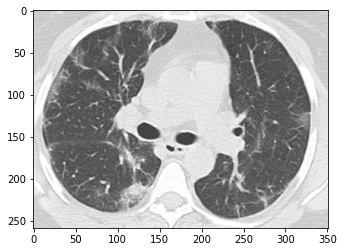

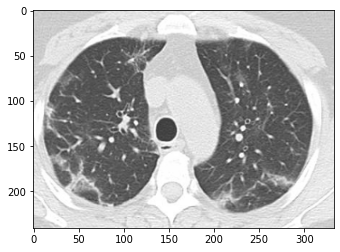

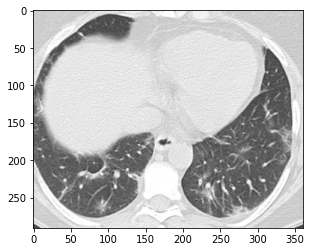

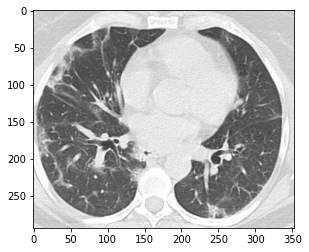

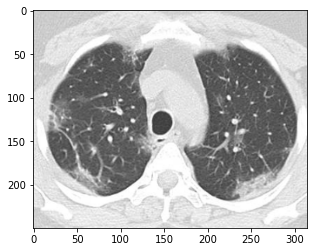

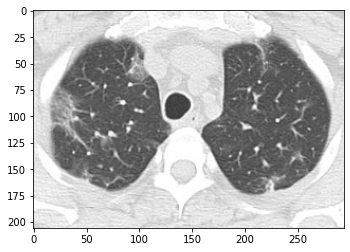

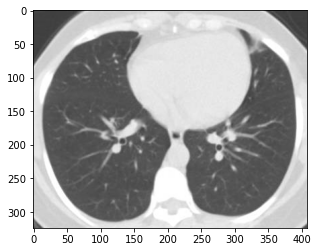

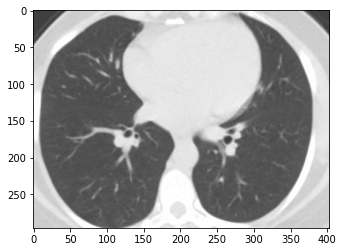

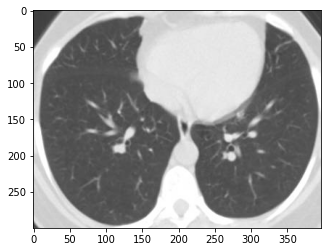

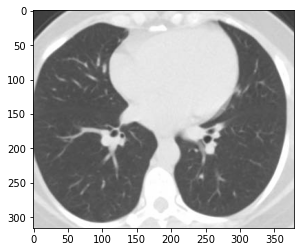

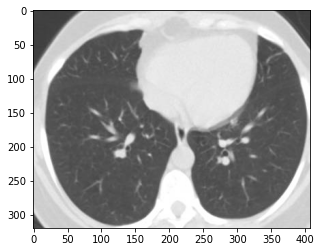

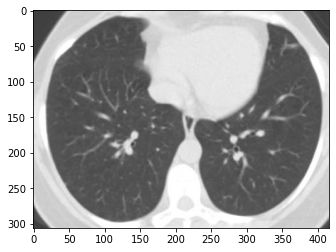

In [5]:
#displaying the raw images before processing
for _,file in enumerate(input_list):
   img = mpimg.imread(file)
   imgplot = plt.imshow(img)
   plt.show()

## Making API Call to Custom Vision Cognitive Service  

Now we will define connections details for making the API call to the Custom Vision Service 


In [5]:
#from msrest.authentication import ApiKeyCredentials
#from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient

# web service end-point foe the Custom Vision model    
# we will process images  
POST_URL = GlobalVariables.CT_SCAN_END_POINT
# providing prediction key
HEADERS = {'Prediction-Key': GlobalVariables.CT_SCAN_PREDICTION_KEY,"Content-Type":"application/octet-stream"}

# number of API calls per pool of request   
MAX_CONNECTIONS = 100

# ENDPOINT = "https://westus2.api.cognitive.microsoft.com/"
# prediction_key = "49e39db7ca5b4274a8d2f019a1968445"
# prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
# predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)


## Functions to Converting Raw Input Images to Processed Images


### function: getFrames

This function takes a  list of image files as input and returns list of frames    


In [8]:
# returns list of arrays from list of images
def getFrames(input_list):
    images = []
    byteImages = []
    for _,k in enumerate(input_list):
        image = cv2.imread(k)
        images.append(image)
    return images

### function: convertCVImagesToByteImages

This function takes a list of frames as input and returns list of Byte arrays 

In [9]:
# returns list of byte arrays
def convertCVImagesToByteImages(frames):
    toReturnByteImages = []
    for frame in frames:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        is_success, im_buf_arr = cv2.imencode(".jpg", image)
        if is_success:
            byte_im = im_buf_arr.tobytes()
            toReturnByteImages.append(byte_im)
    return toReturnByteImages

### function:  fetch_all

This function takes a list of byteImages and returns the list of raw responses


In [10]:
# making async requests call
async def fetch(session, url, data,i):
    print("Request #" + str(i) + " Sent")
    async with session.post(url,headers=HEADERS, data=data) as response:
        resp = await response.text()
        print("Request #"+ str(i) + " Complete")
        return resp

# Setting up for batch requests
async def fetch_all(byteImages):
    conn = aiohttp.TCPConnector(limit=len(byteImages)+1)
    async with aiohttp.ClientSession(connector=conn) as session:
        tasks = []
        i = 0
        for image in byteImages:
            i = i+1
            # if i%20 == 0:
                # time.sleep(3)
            tasks.append( fetch(session, POST_URL, image, i) )

        responses = await asyncio.gather(*tasks, return_exceptions=True)
        return responses


In [11]:
# returns list of raw responses
def batchRequest(byteImages):
    results = []
    for x in range(0,len(byteImages)+1, MAX_CONNECTIONS):
        rs = (grequests.post(POST_URL,headers=HEADERS,data=u,stream=False) for u in byteImages[x:x+MAX_CONNECTIONS])
        time.sleep(0.2)
        results.extend(grequests.map(rs)) 
    for r in results:
        print(r)
    response_list=[response.text for response in results]
    return response_list

### function: getDFfromResponse

This function takes a JSON as input and convert them into dataframe.


In [12]:
# converts JSON to Pandas dataframe 
def getDFfromResponse(response):
    resp = json.loads(response)
    pred_resp= resp['predictions']
    pred_df=pd.DataFrame(pred_resp)
    final_df = pred_df.head(1)
    return final_df

### function: get_label

This function takes predicted label as input and returns the text and color for that label


In [13]:
# returns color and text for given prediction
def get_label(value):
    if value=="positive":
        fill=(255,0,0,255)
        text="Positive"
    else:
        fill=(0,255,0,255)
        text="Healthy"
    return text,fill

### function: process_image

This function converts list of raw images into list of processed images. This function relies on several other functions that are defines above. 


In [14]:
# converts list of raw images to processed images
def process_image(input_list,output_list):
    frames = getFrames(input_list)
    byteImages=convertCVImagesToByteImages(frames)
    loop = asyncio.get_event_loop()
    response_list = loop.run_until_complete(fetch_all(byteImages))
    fontPath = "/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf"
    sans16  =  ImageFont.truetype ( fontPath, 20 )
    
    for i,response in enumerate(response_list):
        print(response)
        df=getDFfromResponse(response)
        tag_value=(df['tagName'].head(1).values)[0]
        text,fill=get_label(tag_value)
        
        # Convert to PIL Image
        cv2_im_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        pil_im = Image.fromarray(cv2_im_rgb)

        draw = ImageDraw.Draw(pil_im)

        # Draw the text
        draw.text((0, 0), text,fill=fill,font=sans16 )

        # Save the image
        cv2_im_pcd = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_list[i], cv2_im_pcd)

## Image Conversion and ADLSGen2 Storage  

We wil make functions call to convert list of raw images to list of processed images and store them to ADLSGen2 storage. 


In [17]:
# converts list of raw images to list of processed images
process_image(input_list,output_list)

Request #6 Sent
Request #7 Sent
Request #5 Sent
Request #2 Sent
Request #9 Sent
Request #4 Sent
Request #12 Sent
Request #1 Sent
Request #11 Sent
Request #3 Sent
Request #10 Sent
Request #8 Sent
Request #10 Complete
Request #6 Complete
Request #4 Complete
Request #12 Complete
Request #2 Complete
Request #3 Complete
Request #9 Complete
Request #5 Complete
Request #8 Complete
Request #7 Complete
Request #11 Complete
Request #1 Complete
{"id":"65119249-48dc-4b48-9aa0-dd5e6430c869","project":"69c4309e-2d3c-4607-97cf-22929c73cad3","iteration":"beccd41d-e7d9-4eb0-90c6-efb3af8740cc","created":"2020-12-21T22:56:14.758Z","predictions":[{"probability":0.9999993,"tagId":"22fa2b7e-d0c4-4769-92f8-701aad6857a2","tagName":"covid-positive"},{"probability":7.599202E-07,"tagId":"55bca730-18d3-4057-a166-2484dee10a81","tagName":"covid-negative"}]}
{"id":"b9b3b5cf-f63f-4fdd-9075-2864aeedc3d4","project":"69c4309e-2d3c-4607-97cf-22929c73cad3","iteration":"beccd41d-e7d9-4eb0-90c6-efb3af8740cc","created":"2020

### Displaying Processed images


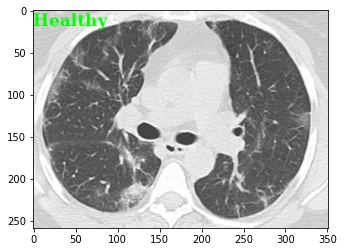

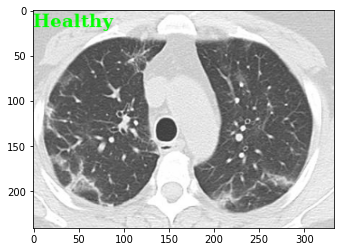

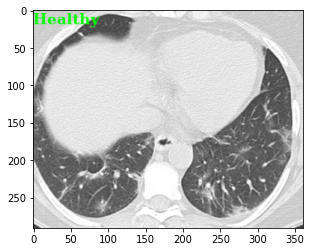

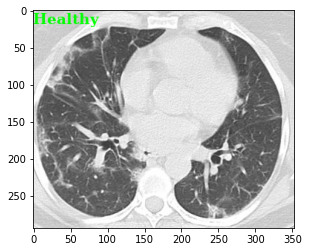

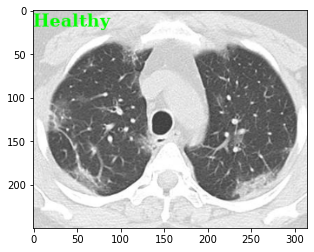

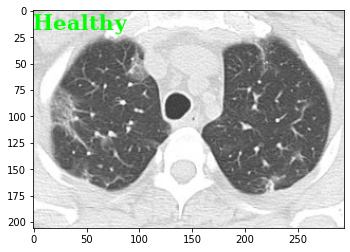

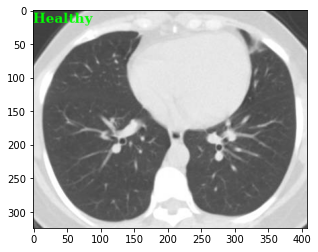

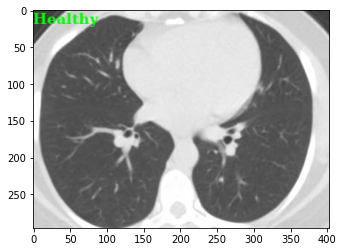

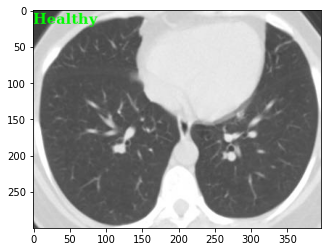

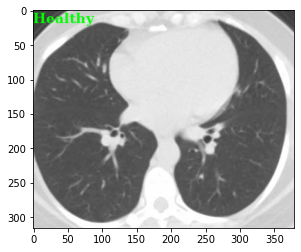

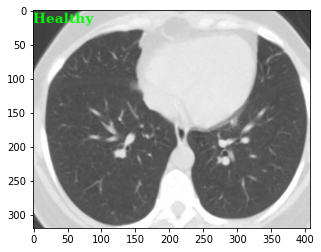

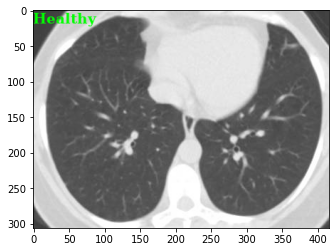

In [18]:
# displays the final processed images
for _,file in enumerate(output_list):
   img = mpimg.imread(file)
   imgplot = plt.imshow(img)
   plt.show()